# Verification: CRPS and CRPSS for Unet baseline 

In [1]:
import os
import sys
import time
import numpy as np
from glob import glob
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator

import h5py

In [2]:
import numba as nb

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import verif_utils as vu

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

In [6]:
N_days = 300
grid_shape = lon_GFS.shape

N_ens = 10

name_base = '/glade/campaign/cisl/aiml/ksha/LDM_baseline/Baseline_025_2023_ini00_lead{:02d}.hdf'
name_MRMS = '/glade/campaign/cisl/aiml/ksha/GFS/MRMS_3H_lead{:02d}_2023.hdf'

In [7]:
edge_left = 4
edge_right = -8
edge_bot = 2
edge_top = -1

grid_shape_cut = (grid_shape[0] - edge_bot + edge_top, grid_shape[1] - edge_left + edge_right)

In [8]:
result_dir

'/glade/work/ksha/GAN_result/'

**CRPS from Unet outputs**

In [32]:
CRPS_base_lead = np.empty((N_days, grid_shape_cut[0], grid_shape_cut[1]))

#LEADs = [3,]
LEADs = np.arange(3, 168+3, 3)

for lead in LEADs:
    CRPS_base_lead[...] = np.nan
    
    with h5py.File(name_base.format(lead), 'r') as h5io:
        Y_PRED = h5io['Y_PRED'][:, :, edge_bot:edge_top, edge_left:edge_right]
    
    with h5py.File(name_MRMS.format(lead), 'r') as h5io:
        MRMS_lead = h5io['MRMS_lead'][:, edge_bot:edge_top, edge_left:edge_right]/3
        
    Y_PRED_flat = Y_PRED.reshape(N_days, N_ens, grid_shape_cut[0]*grid_shape_cut[1])
    MRMS_lead_flat = MRMS_lead.reshape(N_days, grid_shape_cut[0]*grid_shape_cut[1])
    
    for d in range(N_days):
        flag_nan = np.sum(np.isnan(MRMS_lead_flat[d, :])) + np.sum(np.isnan(Y_PRED_flat[d, :]))
        if flag_nan == 0:
            crps_, _, _ = vu.CRPS_1d_nan(MRMS_lead_flat[d, :][None, ...], Y_PRED_flat[d, ...][None, ...])        
            CRPS_base_lead[d, ...] = crps_[0, :].reshape(grid_shape_cut[0], grid_shape_cut[1])
        else:
            CRPS_base_lead[d, ...] = np.nan
    
    # save
    #print(np.nanmean(CRPS_base_lead))
    tuple_save = (CRPS_base_lead,)
    label_save = ['CRPS_base',]
    du.save_hdf5(tuple_save, label_save, '/glade/work/ksha/GAN_result/', 
                 'Baseline_025_CRPS_2023_ini00_f{:02d}.hdf'.format(lead))

Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f03.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f06.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f09.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f12.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f15.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f18.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f21.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f24.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f27.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f30.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f33.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f36.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f39.hdf
Save to /glade/work/ksha/GAN_result/Baseline_025_CR

In [33]:
crps_base_name = '/glade/work/ksha/GAN_result/Baseline_025_CRPS_2023_ini00_f{:02d}.hdf'
crps_climo_name = '/glade/work/ksha/GAN_result/CRPS_MRMS_3H_lead{:02d}_Climo_2023.hdf'

LEADs = np.arange(3, 168+3, 3)

CRPS_base_series = np.empty(len(LEADs))
CRPS_climo = np.empty(len(LEADs))

for l, lead in enumerate(LEADs): 
    with h5py.File(crps_base_name.format(lead), 'r') as h5io:
        crps_ = h5io['CRPS_base'][...]
    CRPS_base_series[l] = np.nanmean(crps_)

    with h5py.File(crps_climo_name.format(lead), 'r') as h5io:
        crps_ = h5io['CRPS_climo_lead'][...]
    CRPS_climo[l] = np.nanmean(crps_)
    
    #print('{} {}'.format(lead, np.nanmean(crps_)))

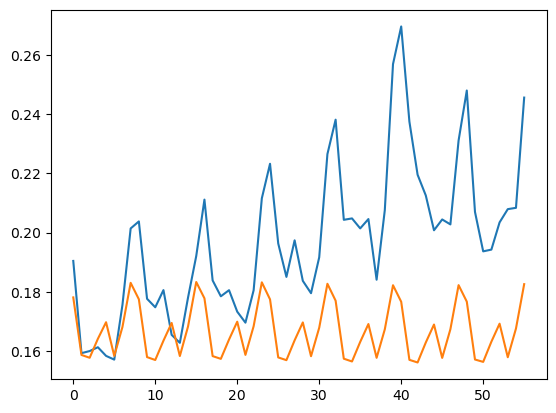

In [35]:
plt.plot(CRPS_base_series)
plt.plot(CRPS_climo)

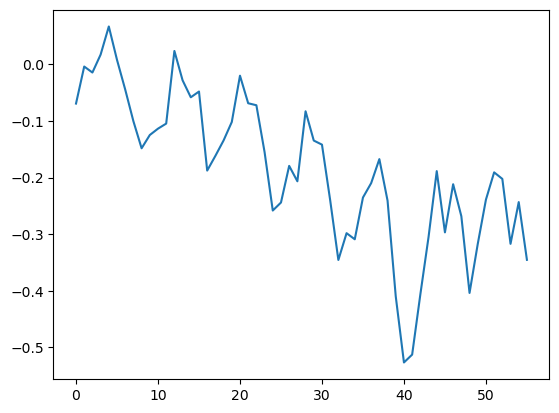

In [36]:
plt.plot(1-CRPS_base_series/CRPS_climo)

In [15]:
with h5py.File(crps_base_name.format(3), 'r') as h5io:
    crps_3 = h5io['CRPS_base'][...]

In [23]:
with h5py.File(name_base.format(3), 'r') as h5io:
    Y_PRED_3 = h5io['Y_PRED'][:, :, edge_bot:edge_top, edge_left:edge_right]

with h5py.File(name_MRMS.format(3), 'r') as h5io:
    MRMS_lead_3 = h5io['MRMS_lead'][:, edge_bot:edge_top, edge_left:edge_right]

In [31]:
CRPS_base_lead = np.empty((N_days, grid_shape_cut[0], grid_shape_cut[1]))
CRPS_base_lead[...] = np.nan

Y_PRED_flat = Y_PRED_3.reshape(N_days, N_ens, grid_shape_cut[0]*grid_shape_cut[1])
MRMS_lead_flat = MRMS_lead_3.reshape(N_days, grid_shape_cut[0]*grid_shape_cut[1])

for d in range(N_days):
    flag_nan = np.sum(np.isnan(MRMS_lead_flat[d, :])) + np.sum(np.isnan(Y_PRED_flat[d, :]))
    if flag_nan == 0:
        crps_, _, _ = vu.CRPS_1d_nan(MRMS_lead_flat[d, :][None, ...]/3, Y_PRED_flat[d, ...][None, ...])        
        CRPS_base_lead[d, ...] = crps_[0, :].reshape(grid_shape_cut[0], grid_shape_cut[1])
    else:
        CRPS_base_lead[d, ...] = np.nan

print(np.nanmean(CRPS_base_lead))

0.20514442926837398


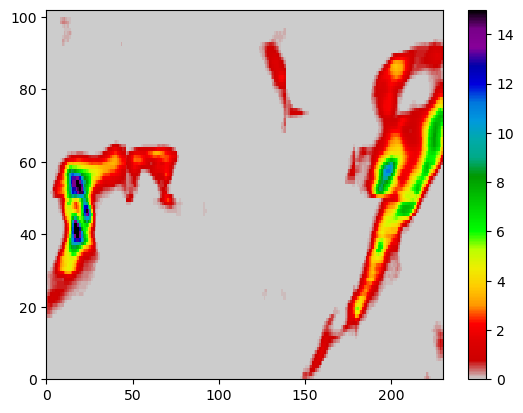

In [26]:
plt.pcolormesh(Y_PRED_3[0, 0, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

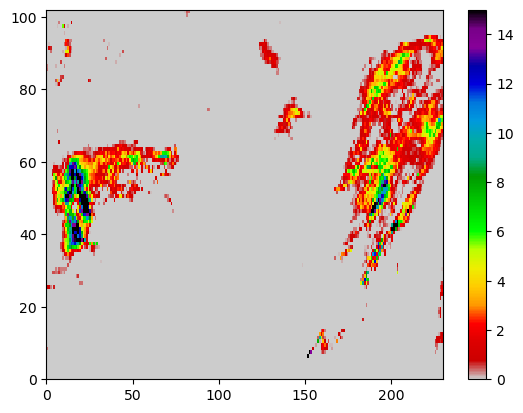

In [27]:
plt.pcolormesh(MRMS_lead_3[0, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

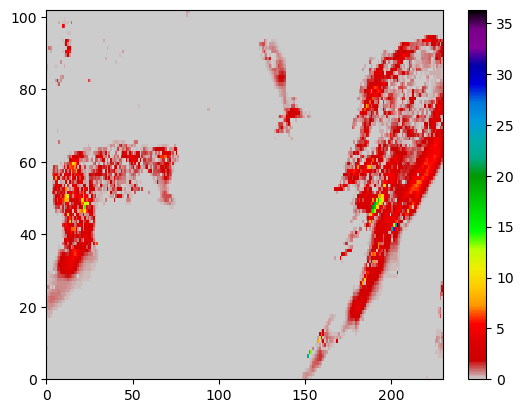

In [28]:
plt.pcolormesh(crps_3[0, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()